In [17]:
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns

# Getting the closest embedded charts

In [2]:
# open biomed_clip
biomedCLIP = pd.read_parquet('embeddings/biomedclip_embeddings.parquet')
biomedCLIP.head()

,image,top_label,clip_embeddings
0,screenshots/heatmap_sw_1_2_s_1_0.png,heatmap,"[0.022331731, 0.007818277, -0.16542432, 0.0080..."
1,screenshots/two_by_two_p_4_m_10_sw_0_7_s_1_2.png,genomics visualization,"[0.019216416, 0.03744839, -0.12684523, -0.0058..."
2,screenshots/multiple_view_p_2_m_12_sw_0_7_s_0_...,circular genomic visualization,"[-0.0016217616, -0.051115554, -0.07445832, -0...."
3,screenshots/two_by_two_uneven_w_m_20_sw_0_7_s_...,genomics visualization,"[-0.0015807527, 0.038776863, -0.13082261, 0.05..."
4,screenshots/multiple_view_p_1_m_8_sw_1_2_s_1_0...,circular genomic visualization,"[-0.002367256, -0.0421267, -0.04676023, -0.033..."


In [5]:
import open_clip
import torch

model, preprocess_train, preprocess_val = open_clip.create_model_and_transforms('hf-hub:microsoft/BiomedCLIP-PubMedBERT_256-vit_base_patch16_224')
tokenizer = open_clip.get_tokenizer('hf-hub:microsoft/BiomedCLIP-PubMedBERT_256-vit_base_patch16_224')

In [51]:
def get_image_features(image_path):
    image = Image.open(image_path)
    inputs = preprocess_val(image).unsqueeze(0)
    with torch.no_grad():
        image_features = model.encode_image(inputs)
    return image_features.numpy().flatten()

def cosine_similarity(a, b):
    return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))

def most_similar(embedding, embeddings, top_n=5):
    similarities = np.array([cosine_similarity(embedding, emb) for emb in embeddings])
    return np.argsort(similarities)[::-1][:top_n]

def display_images(img_paths):
    # concatenate images horizontally and display
    images = [Image.open(img_path) for img_path in img_paths]
    padding = 100
    widths, heights = zip(*(i.size for i in images))
    total_width = sum(widths) + padding * (len(images) - 1)
    max_height = max(heights)
    new_im = Image.new('RGB', (total_width, max_height))
    # Make the background white
    new_im.paste((255, 255, 255), (0, 0, total_width, max_height))

    x_offset = 0
    for im in images:
        new_im.paste(im, (x_offset, 0))
        x_offset += im.size[0] + padding
    # open image with matplotlib
    plt.figure(figsize=(20, 20))
    plt.imshow(new_im)
    plt.axis('off')

The 5 most similar images using biomedCLIP are the following:


['screenshots/gray_heatmap_sw_1_2_s_0_7.png',
 'screenshots/gray_heatmap_sw_1_0_s_0_7.png',
 'screenshots/gray_heatmap_sw_1_2_s_0_5.png',
 'screenshots/gray_heatmap_sw_0_7_s_0_5.png',
 'screenshots/gray_heatmap_sw_0_7_s_1_0.png']

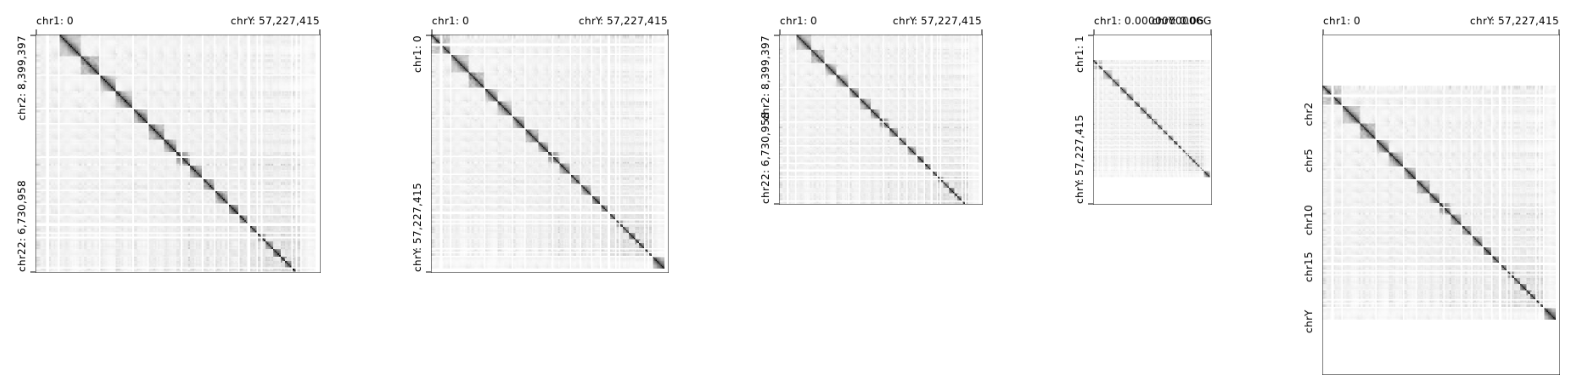

In [67]:
query_embedding = get_image_features("heatmap.png")
# Find the 5 most similar images using biomedCLIP
biomedCLIP_embeddings = np.array(biomedCLIP['clip_embeddings'].to_list())
top_5 = most_similar(query_embedding, biomedCLIP_embeddings, top_n=5)
# Extract the image paths from the dataframe
img_paths = biomedCLIP.loc[top_5]['image'].to_list()
print('The 5 most similar images using biomedCLIP are the following:')
# helper function to show all the images in a row
display_images(img_paths)
img_paths

The 5 most similar images using biomedCLIP are the following:


['screenshots/two_vertical_m_2_sw_1_2_s_0_5.png',
 'screenshots/two_vertical_m_6_sw_1_0_s_1_0.png',
 'screenshots/basic_two_vertical_p_0_m_6_sw_1_0_s_1_0.png',
 'screenshots/two_vertical_m_1_sw_1_2_s_0_5.png',
 'screenshots/two_vertical_m_5_sw_1_0_s_1_0.png']

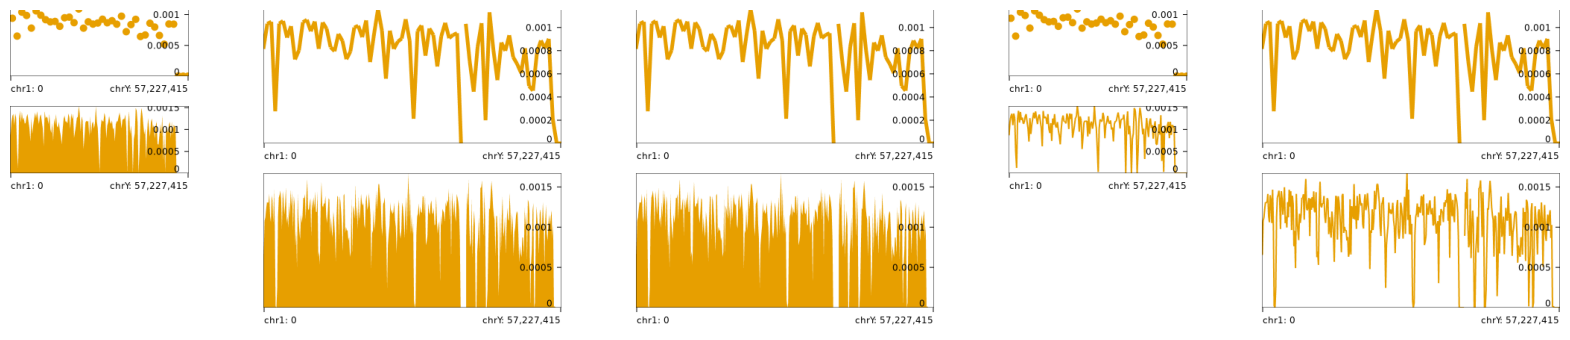

In [68]:
query_embedding = get_image_features("yellow.png")
# Find the 5 most similar images using biomedCLIP
biomedCLIP_embeddings = np.array(biomedCLIP['clip_embeddings'].to_list())
top_5 = most_similar(query_embedding, biomedCLIP_embeddings, top_n=5)
# Extract the image paths from the dataframe
img_paths = biomedCLIP.loc[top_5]['image'].to_list()
print('The 5 most similar images using biomedCLIP are the following:')
# helper function to show all the images in a row
display_images(img_paths)
img_paths

The 5 most similar images using biomedCLIP are the following:


['screenshots/multi_view_circular_ideograms_m_0_sw_0_5_s_1_0.png',
 'screenshots/multi_view_circular_ideograms_m_0_sw_0_7_s_0_7.png',
 'screenshots/multi_view_circular_ideograms_m_1_sw_1_2_s_0_5.png',
 'screenshots/multi_view_circular_ideograms_m_0_sw_1_0_s_0_5.png',
 'screenshots/multi_view_circular_ideograms_m_1_sw_1_0_s_0_7.png']

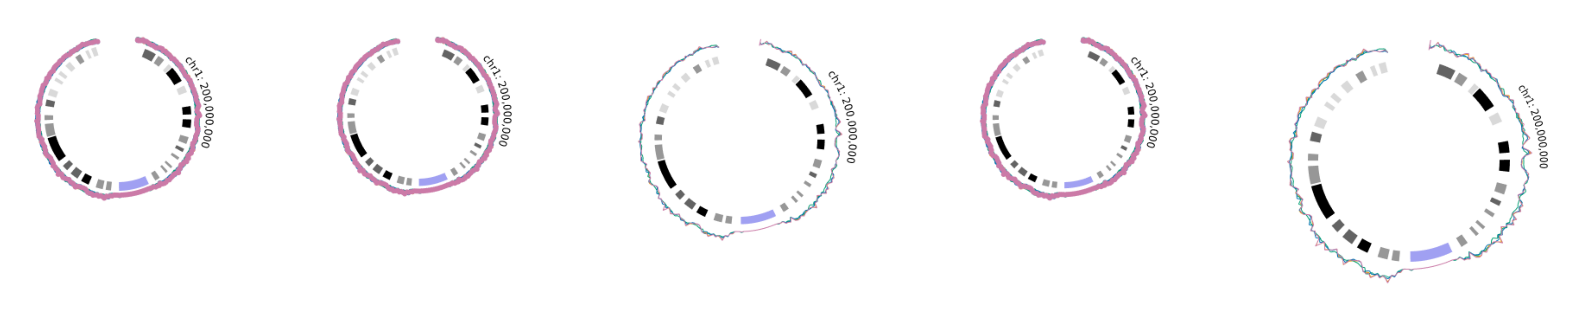

In [69]:
query_embedding = get_image_features("ideogram.png")
# Find the 5 most similar images using biomedCLIP
biomedCLIP_embeddings = np.array(biomedCLIP['clip_embeddings'].to_list())
top_5 = most_similar(query_embedding, biomedCLIP_embeddings, top_n=5)
# Extract the image paths from the dataframe
img_paths = biomedCLIP.loc[top_5]['image'].to_list()
print('The 5 most similar images using biomedCLIP are the following:')
# helper function to show all the images in a row
display_images(img_paths)
img_paths

# Where are the k-nearest CLIP neighbors?

Idea: look at the k-nearest neighbors of the CLIP embeddings of the images in the dataset. 

In [37]:
k_nearest_CLIP = ['screenshots/three_composite_v_m_16_sw_1_2_s_0_7.png',
 'screenshots/two_by_two_p_3_m_15_sw_1_0_s_1_0.png',
 'screenshots/two_by_two_sq_uneven_h_m_12_sw_1_0_s_0_7.png',
 'screenshots/three_composite_v_m_0_sw_1_2_s_0_7.png',
 'screenshots/two_by_two_uneven_w_m_18_sw_2_0_s_2_0.png']
k_nearest_BiomedCLIP = img_paths

def filter_k_nearest(x):
    if x in k_nearest_CLIP:
        return 'k-nearest CLIP'
    elif x in k_nearest_BiomedCLIP:
        return 'k-nearest BiomedCLIP'
    else:
        return 'other'


biomedCLIP['k_nearest'] = biomedCLIP['image'].apply(filter_k_nearest)
biomedCLIP[biomedCLIP['k_nearest'] != 'other']

,image,top_label,clip_embeddings,k_nearest,UMAP_1,UMAP_2
269,screenshots/three_composite_v_m_0_sw_1_2_s_0_7...,lollipop plot,"[0.027313514, 0.014070141, -0.15203507, 0.0026...",k-nearest CLIP,2.960198,4.220961
669,screenshots/three_composite_v_m_16_sw_1_2_s_0_...,genomics visualization,"[0.025293134, 0.02501864, -0.13422446, 0.00355...",k-nearest CLIP,2.770437,3.878247
893,screenshots/gray_heatmap_sw_0_7_s_2_0.png,dot plot,"[0.005140543, -0.03111468, -0.2212361, 0.01091...",k-nearest BiomedCLIP,21.161245,10.287185
1422,screenshots/gray_heatmap_sw_0_7_s_0_5.png,dot plot,"[0.0016323974, -0.009277622, -0.22120649, 0.00...",k-nearest BiomedCLIP,21.214605,10.334708
1699,screenshots/two_by_two_uneven_w_m_18_sw_2_0_s_...,genomics visualization,"[0.04718245, -0.02002444, -0.10414661, -0.0118...",k-nearest CLIP,3.414938,3.104557
2311,screenshots/two_by_two_p_3_m_15_sw_1_0_s_1_0.png,genomics visualization,"[0.010720835, 0.02112277, -0.1080978, -0.00446...",k-nearest CLIP,0.637957,2.165826
3137,screenshots/gray_heatmap_sw_1_2_s_0_5.png,dot plot,"[-0.013963349, -0.0032650034, -0.14855704, 0.0...",k-nearest BiomedCLIP,21.122660,10.425764
3222,screenshots/gray_heatmap_sw_1_2_s_0_7.png,dot plot,"[-0.015725426, -0.005120972, -0.15048325, -0.0...",k-nearest BiomedCLIP,21.231791,10.262691
3563,screenshots/two_by_two_sq_uneven_h_m_12_sw_1_0...,genomics visualization,"[0.0036518015, 0.019489735, -0.09199709, 0.014...",k-nearest CLIP,1.636930,3.394901
7065,screenshots/gray_heatmap_sw_1_0_s_0_7.png,dot plot,"[-0.0067911507, -0.0032393485, -0.16441633, -0...",k-nearest BiomedCLIP,21.093767,10.375655


In [38]:
import umap
# Assuming 'df' is your DataFrame and it contains an 'embeddings' column with your embeddings data
# Convert embeddings list into a proper format if necessary
embeddings = list(biomedCLIP['clip_embeddings'])

# Initialize UMAP. Reduce dimensionality to 2D for easy visualization.
# Create a UMAP instance with custom parameters
reducer = umap.UMAP(
    n_neighbors=50,
    n_components=2,
    metric='euclidean',
    min_dist=0.5,
    spread=0.5,
    learning_rate=1.0,
    n_epochs=200,
    init='spectral'
)
umap_embeddings = reducer.fit_transform(embeddings)

# Create a DataFrame with the UMAP embeddings
embedding_df = pd.DataFrame(umap_embeddings, columns=['UMAP_1', 'UMAP_2'])

biomedCLIP['UMAP_1'] = embedding_df['UMAP_1']
biomedCLIP['UMAP_2'] = embedding_df['UMAP_2']

<Axes: xlabel='UMAP_1', ylabel='UMAP_2'>

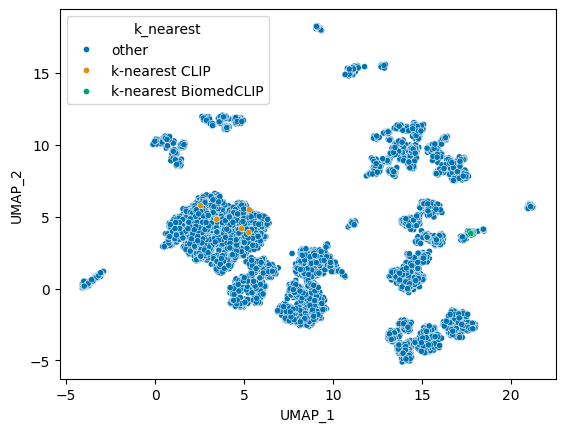

In [39]:
sorted_biomedCLIP = biomedCLIP.sort_values(by='k_nearest', ascending=False)

sns.scatterplot(data=sorted_biomedCLIP, x='UMAP_1', y='UMAP_2', hue='k_nearest', s=20, palette="colorblind")

In [24]:
biomedCLIP[biomedCLIP['k_nearest'] != 'other']

,image,top_label,clip_embeddings,k_nearest,UMAP_1,UMAP_2
815,screenshots/two_by_two_p_2_m_10_sw_0_7_s_0_7.png,genomics visualization,"[-0.030141572, 0.0185646, -0.096780546, 0.0491...",k-nearest CLIP,-0.109983,3.734119
893,screenshots/gray_heatmap_sw_0_7_s_2_0.png,dot plot,"[0.005140543, -0.03111468, -0.2212361, 0.01091...",k-nearest BiomedCLIP,21.161245,10.287185
1306,screenshots/gray_heatmap_sw_0_7_s_0_7.png,multiple seqeunce alignment,"[-0.024379717, -0.016413085, -0.20315216, -0.0...",k-nearest BiomedCLIP,21.072950,10.432398
1422,screenshots/gray_heatmap_sw_0_7_s_0_5.png,dot plot,"[0.0016323974, -0.009277622, -0.22120649, 0.00...",k-nearest BiomedCLIP,21.214605,10.334708
2224,screenshots/two_by_two_p_3_m_15_sw_1_0_s_1_2.png,genomics visualization,"[0.01514291, 0.018744858, -0.109613895, -0.024...",k-nearest CLIP,1.263004,2.008321
2385,screenshots/two_by_two_p_2_m_4_sw_0_7_s_0_7.png,genomics visualization,"[-0.008185099, 0.044378895, -0.09798093, 0.038...",k-nearest CLIP,0.294345,3.478067
2404,screenshots/two_by_two_p_0_m_20_sw_0_7_s_0_7.png,genomics visualization,"[-0.02990349, 0.024358692, -0.1158619, 0.05179...",k-nearest CLIP,-0.086423,3.803149
4702,screenshots/gray_heatmap_sw_0_5_s_0_7.png,dot plot,"[0.0016964141, -0.012607381, -0.23776785, 0.01...",k-nearest BiomedCLIP,21.205070,10.306578
5336,screenshots/gray_heatmap_sw_0_5_s_0_5.png,multiple seqeunce alignment,"[-0.01419733, -0.006977891, -0.23693578, 0.030...",k-nearest BiomedCLIP,21.007072,10.478365
5892,screenshots/two_by_two_p_2_m_13_sw_0_7_s_0_7.png,lollipop plot,"[-0.016385216, 0.03219552, -0.092573486, 0.044...",k-nearest CLIP,-0.074690,3.355268


<Axes: xlabel='UMAP_1', ylabel='UMAP_2'>

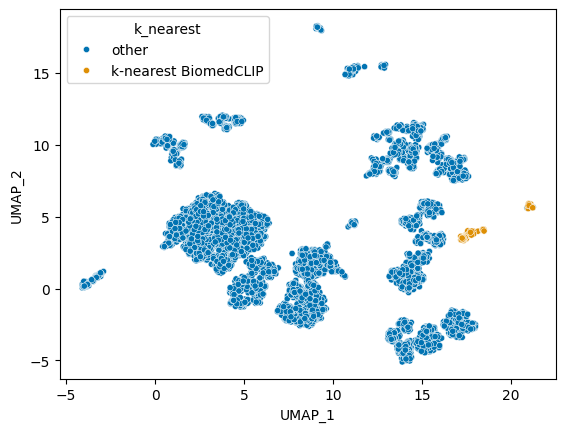

In [47]:
# Find the 5 most similar images using biomedCLIP
biomedCLIP_embeddings = np.array(biomedCLIP['clip_embeddings'].to_list())
top_5 = most_similar(query_embedding, biomedCLIP_embeddings, top_n=80)
# Extract the image paths from the dataframe
img_paths = biomedCLIP.loc[top_5]['image'].to_list()

def filter_k_nearest(x):
    if x in img_paths:
        return 'k-nearest BiomedCLIP'
    else:
        return 'other'


biomedCLIP['k_nearest'] = biomedCLIP['image'].apply(filter_k_nearest)
sorted_biomedCLIP = biomedCLIP.sort_values(by='k_nearest', ascending=False)
sns.scatterplot(data=sorted_biomedCLIP, x='UMAP_1', y='UMAP_2', hue='k_nearest', s=20, palette="colorblind")